# scraping

In [1]:
import pandas as pd

In [2]:
import requests
import bs4

In [3]:
def get_years():
    url = 'http://www.nwac.us/avalanche-forecast/archives/'
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    dropdown = soup.find('select', attrs={'name': 'year'})
    years = [obj.attrs['value'] for obj in dropdown.findAll('option')]
    return years

In [4]:
get_years()

['2015', '2014', '2013', '2016']

In [5]:
def get_months(year):
    fmt = 'http://www.nwac.us/avalanche-forecast/archives/months/?year={year}'
    r = requests.get(fmt.format(year=year))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    dropdown = soup.find('select', attrs={'name': 'month'})
    months = [obj.attrs['value'] for obj in dropdown.findAll('option')]
    return months

In [6]:
get_months(2015)

['December', 'October', 'June', 'April', 'March', 'February', 'January']

In [7]:
import re
renum = re.compile(r'\d+')

def get_forecast_list(month, year):
    fmt = 'http://www.nwac.us/avalanche-forecast/archives/days/?month={month}&year={year}'
    r = requests.get(fmt.format(year=year, month=month))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')
    main = soup.find('div', attrs={'id': 'main-content'})
    links = main.findAll('a')
    results = []
    for link in links:
        url = link.attrs['href']
        forecast_id = int(renum.search(url).group(0))
        date = str(link.contents[0].lstrip())
        results.append((date,forecast_id))
    return results

In [8]:
get_forecast_list('January', '2016')

[('Jan. 31, 2016', 498),
 ('Jan. 30, 2016', 497),
 ('Jan. 30, 2016', 496),
 ('Jan. 29, 2016', 495),
 ('Jan. 28, 2016', 494),
 ('Jan. 27, 2016', 493),
 ('Jan. 27, 2016', 492),
 ('Jan. 26, 2016', 491),
 ('Jan. 25, 2016', 490),
 ('Jan. 24, 2016', 489),
 ('Jan. 23, 2016', 488),
 ('Jan. 22, 2016', 487),
 ('Jan. 21, 2016', 486),
 ('Jan. 21, 2016', 485),
 ('Jan. 21, 2016', 484),
 ('Jan. 20, 2016', 483),
 ('Jan. 19, 2016', 482),
 ('Jan. 18, 2016', 481),
 ('Jan. 17, 2016', 480),
 ('Jan. 16, 2016', 479),
 ('Jan. 15, 2016', 478),
 ('Jan. 15, 2016', 477),
 ('Jan. 14, 2016', 476),
 ('Jan. 13, 2016', 475),
 ('Jan. 12, 2016', 474),
 ('Jan. 12, 2016', 473),
 ('Jan. 11, 2016', 472),
 ('Jan. 10, 2016', 471),
 ('Jan. 9, 2016', 470),
 ('Jan. 8, 2016', 469),
 ('Jan. 7, 2016', 468),
 ('Jan. 6, 2016', 467),
 ('Jan. 5, 2016', 466),
 ('Jan. 4, 2016', 465),
 ('Jan. 4, 2016', 464),
 ('Jan. 3, 2016', 463),
 ('Jan. 2, 2016', 462),
 ('Jan. 1, 2016', 461)]

# Forecasts

In [9]:
def trim(string, lead):
    assert string[:len(lead)] == lead
    return string[len(lead):]

def get_forecast(forecast_id):
    fmt = 'http://www.nwac.us/avalanche-forecast/avalanche-forecast/{num}/'
    r = requests.get(fmt.format(num=forecast_id))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')

    date = str(soup.find('div', attrs={'class': 'forecast-date'}).contents[0].strip())
    author = str(soup.find('div', attrs={'class': 'forecaster'}).contents[0].strip())
    forecasts = soup.findAll('a', attrs={'class': 'forecast'})
    
    results = []
    for forecast in forecasts:
        region = str(forecast.find('span').contents[0].strip())
        url = forecast.attrs['href']
        subforecast_id = int(renum.search(url).group(0))
        results.append((region, subforecast_id))
    
    return trim(date, 'Issued: '), trim(author, 'by '), results

In the archive, note that frequently all east-side regions link to the same report:

In [10]:
get_forecast(274)

('6:38 AM PST Tuesday, December 23, 2014',
 'Garth Ferber',
 [('Olympics', 921),
  ('West Slopes North - Canadian Border to Skagit River', 922),
  ('West Slopes Central - Skagit River to South of I-90', 923),
  ('West Slopes South - South of I-90 to Columbia River', 923),
  ('Stevens Pass', 923),
  ('Snoqualmie Pass', 923),
  ('East Slopes North - Canadian Border to Lake Chelan', 924),
  ('East Slopes Central - Lake Chelan to South of I-90', 924),
  ('East Slopes South - South of I-90 to Columbia River', 925),
  ('Mt Hood', 926)])

In [11]:
get_forecast(486)

('7:57 AM PST Thursday, January 21, 2016',
 "Dennis D'Amico",
 [('Olympics', 1966),
  ('West Slopes North - Canadian Border to Skagit River', 1967),
  ('West Slopes Central - Skagit River to South of I-90', 1968),
  ('West Slopes South - South of I-90 to Columbia River', 1968),
  ('Stevens Pass', 1968),
  ('Snoqualmie Pass', 1968),
  ('East Slopes North - Canadian Border to Lake Chelan', 1969),
  ('East Slopes Central - Lake Chelan to South of I-90', 1970),
  ('East Slopes South - South of I-90 to Columbia River', 1970),
  ('Mt Hood', 1971)])

In [12]:
get_forecast(461)

('6:00 PM PST Thursday, December 31, 2015',
 "Dennis D'Amico",
 [('Olympics', 1850),
  ('West Slopes North - Canadian Border to Skagit River', 1851),
  ('West Slopes Central - Skagit River to South of I-90', 1851),
  ('West Slopes South - South of I-90 to Columbia River', 1851),
  ('Stevens Pass', 1851),
  ('Snoqualmie Pass', 1851),
  ('East Slopes North - Canadian Border to Lake Chelan', 1852),
  ('East Slopes Central - Lake Chelan to South of I-90', 1852),
  ('East Slopes South - South of I-90 to Columbia River', 1852),
  ('Mt Hood', 1853)])

In [13]:
get_forecast(37)

('2:36 PM PST Tuesday, December 10, 2013',
 'Kenny Kramer',
 [('Olympics', 73),
  ('Stevens Pass', 73),
  ('Snoqualmie Pass', 73),
  ('Mt Hood', 73),
  ('White Pass', 73),
  ('WA Cascades near and west of crest - between Snoqualmie and White Pass',
   73),
  ('East slopes WA Cascades - between Stevens and Snoqualmie Pass', 73),
  ('WA Cascades near and west of crest - north of Stevens Pass', 73),
  ('WA Cascades near and west of crest - south of White Pass', 73),
  ('East slopes WA Cascades - between Snoqualmie and White Pass', 73),
  ('WA Cascades near and west of crest - between Stevens and Snoqualmie Pass',
   73),
  ('East slopes WA Cascades - north of Stevens Pass', 73),
  ('East slopes WA Cascades - south of White Pass', 73)])

test date string conversion. it puts it in UTC for us

In [14]:
_[0]

'2:36 PM PST Tuesday, December 10, 2013'

In [15]:
#pandas.to_datetime(_, utc=True)
pd.to_datetime(_)

Timestamp('2013-12-10 22:36:00')

# Reports

A forecast contains multiple reports, each individualized to a geographic sub-region of the NWAC forecast area.

In [16]:
def get_report(subforecast_id):
    fmt = 'http://www.nwac.us/avalanche-forecast/avalanche-region-forecast/{num}/'
    r = requests.get(fmt.format(num=subforecast_id))
    soup = bs4.BeautifulSoup(r.text, 'html5lib')

    date = str(soup.find('div', attrs={'class': 'forecast-date'}).contents[0].strip())
    author = str(soup.find('div', attrs={'class': 'forecaster'}).contents[0].strip())
    region = str(soup.find('h2').contents[0].strip())
    
    summary = soup.find('div', attrs={'class': 'forecast-summary'})
    if summary is None:
        summary = soup.find('div', attrs={'class': 'special-header-notes'})
    summary = str(summary.text).strip().replace(u'\xa0', u' ')
    
    areas = ['treeline-above',
             'treeline-near',
             'treeline-below']
    
    ratings = []
    for area in areas:
        rating = find_rating(soup, area)
        ratings.append((area, rating))
    
    return trim(date, 'Issued: '), trim(author, 'by '), region, summary, ratings

def find_rating(soup, area):
    chunk = soup.find('div', attrs={'id': area})
    if chunk is None:
        return None
    rating = chunk.find(
        'div', attrs={'class': 'elev-day1-column'}
            ).find(
        'div', attrs={'class': 'danger-description'}
            ).find('h4').contents[0]
    return str(rating)

In [17]:
get_report(1852)

('6:00 PM PST Thursday, December 31, 2015',
 "Dennis D'Amico",
 'East Slopes North - Canadian Border to Lake Chelan',
 'Watch for isolated areas of wind slab primarily on north through southeast aspects above treeline and for small loose avalanches near terrain traps on steeper slopes throughout the terrain.',
 [('treeline-above', 'Moderate'),
  ('treeline-near', 'Low'),
  ('treeline-below', 'Low')])

In [18]:
get_report(884)

('10:11 AM PST Monday, June 2, 2014',
 'Kenny Kramer',
 'Olympics',
 'Have a safe and enjoyable rest of the spring and we look forward to bringing you even better mountain weather and avalanche forecasts next season! A big thanks to all who help in supporting the Northwest Avalanche Center.  \n\nPlease note that regularly scheduled mountain weather and avalanche forecasts for the past winter season have ended.  However, weather and snow conditions will continue to be monitored through mid-June at the Northwest Weather and Avalanche Center with the information that remains available.  Additional forecasts or special statements will be issued when unusually severe avalanche conditions develop.  When issued such forecasts will be available on the NWAC Web site.',
 [('treeline-above', None), ('treeline-near', None), ('treeline-below', None)])

# Database schema

Organized storage for forecasts and reports, as well as a join table to say which go with which

In [19]:
import sqlalchemy as sa

In [20]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [21]:
metadata = sa.MetaData()

forecast_table = sa.Table('forecasts', metadata,
                          sa.Column('forecast_id', sa.Integer,
                                    primary_key=True, autoincrement=False),
                          sa.Column('date', sa.Text),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.Time),
                          sa.Column('author', sa.Text),
                         )

report_table = sa.Table('reports', metadata,
                        sa.Column('report_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.DateTime),
                          sa.Column('author', sa.Text),
                          sa.Column('region', sa.Text),
                          sa.Column('summary', sa.Text),
                          sa.Column('treeline_above', sa.Text),
                          sa.Column('treeline_near', sa.Text),
                          sa.Column('treeline_below', sa.Text),
                        )

region_index = sa.Table('region_index', metadata,
                        sa.Column('forecast_id', sa.Integer, primary_key=True),
                        sa.Column('region', sa.Text, primary_key=True),
                        sa.Column('report_id', sa.Integer)
                       )

In [ ]:
#report_table.create(engine)

In [22]:
import sqlalchemy_utils as sau

In [23]:
#sau.drop_database(engine.url)
print(sau.database_exists(engine.url))

True


In [24]:
## create a database (if it doesn't exist)
if not sau.database_exists(engine.url):
    sau.create_database(engine.url)
    metadata.create_all(engine)
print(sau.database_exists(engine.url))


True


Feed in an example row

In [25]:
with engine.begin() as conn:
    print (conn.closed)
    pass
print (conn.closed)

False
True


# read in preliminary data.

to empty it, do TRUNCATE TABLE

Insert all in one statement. If there's a problem with any one row, this whole thing fails

In [ ]:
def insert_forecasts_prelim(days):
    with engine.begin() as conn:
        data = [{'forecast_id': fid, 'date': date} for date,fid in days]
        stmt = forecast_table.insert().values(data)
        conn.execute(stmt)

batched queries. Depending on how these loops are nested, only individual things fail

In [41]:
from sqlalchemy.exc import IntegrityError

def insert_forecasts_prelim_batched(days):
    for date,forecast_id in days:
        with engine.begin() as conn:
            stmt = forecast_table.insert().values(date=date, forecast_id=forecast_id)
            try:
                conn.execute(stmt)
            except IntegrityError:
                print("couldn't insert data for date ", date)

for testing:

In [31]:
days = get_forecast_list('February', 2016)
insert_forecasts_prelim_batched(days)

In [42]:
days = get_forecast_list('January', 2016)
insert_forecasts_prelim_batched(days)

couldn't insert data for date  Jan. 31, 2016
couldn't insert data for date  Jan. 30, 2016
couldn't insert data for date  Jan. 30, 2016
couldn't insert data for date  Jan. 29, 2016
couldn't insert data for date  Jan. 28, 2016
couldn't insert data for date  Jan. 27, 2016
couldn't insert data for date  Jan. 27, 2016
couldn't insert data for date  Jan. 26, 2016
couldn't insert data for date  Jan. 25, 2016
couldn't insert data for date  Jan. 24, 2016
couldn't insert data for date  Jan. 23, 2016
couldn't insert data for date  Jan. 22, 2016
couldn't insert data for date  Jan. 21, 2016
couldn't insert data for date  Jan. 21, 2016
couldn't insert data for date  Jan. 21, 2016
couldn't insert data for date  Jan. 20, 2016
couldn't insert data for date  Jan. 19, 2016
couldn't insert data for date  Jan. 18, 2016
couldn't insert data for date  Jan. 17, 2016
couldn't insert data for date  Jan. 16, 2016
couldn't insert data for date  Jan. 15, 2016
couldn't insert data for date  Jan. 15, 2016
couldn't i

# get list of all forecasts ever

and put this in the database as preliminary datas

In [ ]:
def gen_all_reports():
    for year in get_years():
        for month in get_months(year):
            yield from get_forecast_list(month, year)

In [ ]:
insert_forecasts_prelim(gen_all_reports())

In [43]:
pd.read_sql_query('select * from forecasts order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,37,"Dec. 11, 2013","2:36 PM PST Tuesday, December 10, 2013",22:36:00,Kenny Kramer
1,38,"Dec. 11, 2013","2:42 PM PST Tuesday, December 10, 2013",22:42:00,Kenny Kramer
2,39,"Dec. 11, 2013","9:24 PM PST Tuesday, December 10, 2013",05:24:00,Kenny Kramer
3,40,"Dec. 12, 2013","3:26 PM PST Wednesday, December 11, 2013",23:26:00,Garth Ferber
4,47,"Dec. 13, 2013","7:07 PM PST Thursday, December 12, 2013",03:07:00,Dennis D'Amico


In [45]:
pd.read_sql_query('select * from forecasts order by forecast_id desc limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,510,"Feb. 10, 2016",None,None,None
1,509,"Feb. 9, 2016",None,None,None
2,508,"Feb. 8, 2016",None,None,None
3,507,"Feb. 7, 2016",None,None,None
4,506,"Feb. 6, 2016",None,None,None


# Add region data

In [46]:
def load_forecast(forecast_id):
    datetime,author,reg_index = get_forecast(forecast_id)
    datetime_utc = pd.to_datetime(datetime)
    values = dict(datetime=datetime, author=author, datetime_utc=datetime_utc)
    
    with engine.begin() as conn:
        # fill in the rest of the forecast info (update one row)
        stmt = forecast_table.update().where(
                   forecast_table.c.forecast_id==forecast_id
                   ).values(**values)
        conn.execute(stmt)

        # populate the region index (many rows)
        data = [{'region': reg, 'report_id': rid, 'forecast_id': forecast_id} for reg,rid in reg_index]
        stmt2 = region_index.insert().values(data)
        conn.execute(stmt2)

In [ ]:
load_forecast(37)

In [ ]:
pd.read_sql_query('select * from forecasts order by forecast_id limit 5', engine)

In [ ]:
pd.read_sql_query('select * from region_index', engine)

# read in all detailed forecast data

Only where data is missing

In [47]:
pd.read_sql_query('select * from forecasts where datetime_utc is null order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author
0,493,"Jan. 27, 2016",None,None,None
1,494,"Jan. 28, 2016",None,None,None
2,495,"Jan. 29, 2016",None,None,None
3,496,"Jan. 30, 2016",None,None,None
4,497,"Jan. 30, 2016",None,None,None


In [48]:
def fill_forecasts(how_many=5):
    stmt = sa.select(
                    [forecast_table.c.forecast_id]
                ).where(
                    forecast_table.c.author == None
                ).order_by(
                    forecast_table.c.forecast_id.desc()
                ).limit(how_many)
    str(stmt)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    for fid, in result:
        print(fid, end=' ')
        load_forecast(fid)

In [49]:
fill_forecasts()

510 509 508 507 506 

In [50]:
fill_forecasts()

505 504 502 501 500 

In [51]:
fill_forecasts(20)

499 498 497 496 495 494 493 

In [52]:
pd.read_sql_query('select * from forecasts where datetime_utc is null order by forecast_id limit 5', engine)

,forecast_id,date,datetime,datetime_utc,author


In [53]:
def missing_forecasts():
    """How many forecasts are missing?"""
    stmt = sa.select(
                    [sa.func.count(forecast_table.c.forecast_id)]
                ).where(
                    forecast_table.c.author == None
                )
    str(stmt)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    missing, = result.fetchone()
    return missing

In [54]:
missing_forecasts()

0

# Read in Reports

In [55]:
pd.read_sql_query('select * from region_index limit 5', engine)

,forecast_id,region,report_id
0,37,Olympics,73
1,37,Stevens Pass,73
2,37,Snoqualmie Pass,73
3,37,Mt Hood,73
4,37,White Pass,73


In [70]:
pd.read_sql_query('select report_id from region_index order by report_id desc limit 5', engine)

,report_id
0,2085
1,2084
2,2084
3,2084
4,2083


In [56]:
pd.read_sql_query('select distinct report_id from region_index order by report_id desc limit 5', engine)

,report_id
0,2085
1,2084
2,2083
3,2082
4,2081


In [72]:
pd.read_sql_query('select report_id, count(report_id) from region_index '
                  'group by report_id order by report_id desc limit 5', engine)

,report_id,count
0,2085,1
1,2084,3
2,2083,5
3,2082,1
4,2081,1


In [57]:
get_report(2085)

('6:00 PM PST Tuesday, February 9, 2016',
 'Kenny Kramer',
 'Mt Hood',
 'Cooler weather with a few light showers should maintain some shallow wet snow or crust layers. Watch for unexpected wet snow deeper than boot top. The cooler weather should limit the avalanche potential Wednesday.',
 [('treeline-above', 'Low'),
  ('treeline-near', 'Low'),
  ('treeline-below', 'Low')])

In [58]:
def load_report(report_id):
    datetime,author,region,summary,conditions_list = get_report(report_id)
    datetime_utc = pd.to_datetime(datetime)
    conditions_dict = dict((k.replace('-','_'),v) for k,v in conditions_list)
    values = dict(report_id=report_id,
                  datetime=datetime, author=author, datetime_utc=datetime_utc,
                 region=region, summary=summary, **conditions_dict)
    
    with engine.begin() as conn:
        stmt = report_table.insert(
                   ).values(**values)
        conn.execute(stmt)

In [59]:
load_report(2085)

In [60]:
def fill_reports(how_many=5):
    # select report ids from the region index
    # which have no counterpart in the report table,
    # ignoring duplicates (distinct). big nasty query:
    stmt = sa.select(
                    [region_index.c.report_id]
                ).select_from(region_index.outerjoin(report_table,
                        region_index.c.report_id == report_table.c.report_id)
                ).where(
                    report_table.c.report_id == None
                #).where(
                #    region_index.c.report_id <= 1180
                ).order_by(
                    region_index.c.report_id.desc()
                ).distinct().limit(how_many)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    for rid, in result:
        print(rid, end=' ')
        load_report(rid)

In [61]:
def missing_reports():
    stmt = sa.select(
                    [sa.func.count(region_index.c.report_id.distinct())]
                ).select_from(region_index.outerjoin(report_table,
                        region_index.c.report_id == report_table.c.report_id)
                ).where(
                    report_table.c.report_id == None
                )
    str(stmt)

    with engine.begin() as conn:
        result = conn.execute(stmt)

    missing, = result.fetchone()
    return missing

In [62]:
missing_reports()

198

In [63]:
fill_reports(20)

2084 2083 2082 2081 2080 2078 2077 2076 2075 2074 2073 2072 2071 2070 2069 2068 2067 2066 2065 2064 

In [64]:
fill_reports(40)

2063 2062 2060 2059 2058 2057 2056 2055 2054 2047 2046 2045 2044 2043 2042 2041 2040 2039 2038 2037 2036 2035 2034 2033 2032 2031 2029 2028 2027 2026 2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 

In [65]:
missing_reports()

138

In [114]:
fill_reports(40)

2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 270 269 268 267 266 265 264 263 260 259 258 257 256 255 251 246 245 244 243 238 237 236 235 234 233 232 231 

notice it kicked over and started getting the old ones, after recent ones finished arriving

In [ ]:
fill_reports(85)

# Get backlog of data

stagger our scraping. useful when filling DB, to not hammer NWAC too hard

In [66]:
missing_forecasts(), missing_reports()

(0, 138)

In [ ]:
import random
random.randint(1,20)

In [ ]:
from time import sleep

def get_staggered(seconds):
    accumulated = 0
    while accumulated <= seconds:
        fill_forecasts(random.randint(1,3))
        print('')
        fill_reports(random.randint(4,12))
        print('')
        wait = random.randint(2,7)
        accumulated += wait
        sleep(wait)
    return missing_forecasts(), missing_reports()

In [ ]:
get_staggered(60)

In [ ]:
get_staggered(10)

# what regions do we have?

In [67]:
pd.read_sql_query('select distinct region from region_index;', engine)

,region
0,East Slopes North - Canadian Border to Lake Ch...
1,WA Cascades near and west of crest - between S...
2,Mt Hood
3,East slopes WA Cascades - north of Stevens Pass
4,West Slopes South - South of I-90 to Columbia ...
5,Stevens Pass
6,WA Cascades near and west of crest - north of ...
7,West Slopes North - Canadian Border to Skagit ...
8,Snoqualmie Pass
9,WA Cascades near and west of crest - between S...


In [68]:
pd.read_sql_query('select distinct region from reports;', engine)

,region
0,East Slopes North - Canadian Border to Lake Ch...
1,WA Cascades near and west of crest - between S...
2,Mt Hood
3,East slopes WA Cascades - north of Stevens Pass
4,West Slopes South - South of I-90 to Columbia ...
5,Stevens Pass
6,WA Cascades near and west of crest - north of ...
7,West Slopes North - Canadian Border to Skagit ...
8,Snoqualmie Pass
9,White Pass


In [87]:
set(_68['region']) | set(_67['region'])

{'East Slopes Central - Lake Chelan to South of I-90',
 'East Slopes North - Canadian Border to Lake Chelan',
 'East Slopes South - South of I-90 to Columbia River',
 'East slopes WA Cascades - between Snoqualmie and White Pass',
 'East slopes WA Cascades - between Stevens and Snoqualmie Pass',
 'East slopes WA Cascades - north of Stevens Pass',
 'East slopes WA Cascades - south of White Pass',
 'Mt Hood',
 'Olympics',
 'Snoqualmie Pass',
 'Stevens Pass',
 'WA Cascades near and west of crest - between Snoqualmie and White Pass',
 'WA Cascades near and west of crest - between Stevens and Snoqualmie Pass',
 'WA Cascades near and west of crest - north of Stevens Pass',
 'WA Cascades near and west of crest - south of White Pass',
 'West Slopes Central - Skagit River to South of I-90',
 'West Slopes North - Canadian Border to Skagit River',
 'West Slopes South - South of I-90 to Columbia River',
 'White Pass'}

Somewhere along the line, NWAC changed their regions. The 2 southern regions (E/W south of I-90, aka snoqualamie) used to be 4, with a further subdivision at white pass. In the north region, the border between North and central regions was moved north (from stevens pass to Skagit/Chelan.

I'm blurring the line here between I-90 and 'S of I-90', so don't choose any sites in that zone

I will define 10 regions, in place of the 6 existing, formed by the intersection of all these historical divisions

In [89]:
redistricting = [
    ('east-far-north',
     ['East Slopes North - Canadian Border to Lake Chelan', 'East slopes WA Cascades - north of Stevens Pass']),
    ('east-mid-north',
     ['East Slopes Central - Lake Chelan to South of I-90', 'East slopes WA Cascades - north of Stevens Pass']),
    ('east-central',
     ['East Slopes Central - Lake Chelan to South of I-90', 'East slopes WA Cascades - between Stevens and Snoqualmie Pass']),
    ('east-mid-south',
     ['East Slopes South - South of I-90 to Columbia River', 'East slopes WA Cascades - between Snoqualmie and White Pass']),
    ('east-far-south',
     ['East Slopes South - South of I-90 to Columbia River', 'East slopes WA Cascades - south of White Pass']),
    #deep breath
    ('west-far-north',
     ['West Slopes North - Canadian Border to Skagit River', 'WA Cascades near and west of crest - north of Stevens Pass']),
    ('west-mid-north',
     ['West Slopes Central - Skagit River to South of I-90', 'WA Cascades near and west of crest - north of Stevens Pass']),
    ('west-central',
     ['West Slopes Central - Skagit River to South of I-90', 'WA Cascades near and west of crest - between Stevens and Snoqualmie Pass']),
    ('west-mid-south',
     ['West Slopes South - South of I-90 to Columbia River', 'WA Cascades near and west of crest - between Snoqualmie and White Pass']),
    ('west-far-south',
     ['West Slopes South - South of I-90 to Columbia River', 'WA Cascades near and west of crest - south of White Pass']),
]

In [73]:
pd.read_sql_query('select count(region) from region_index;', engine)

,count
0,4776


In [74]:
pd.read_sql_query('select count(region) from reports;', engine)

,count
0,1544


In [78]:
pd.read_sql_query('select region, count(region) from region_index group by region;', engine)

,region,count
0,East Slopes North - Canadian Border to Lake Ch...,228
1,WA Cascades near and west of crest - between S...,192
2,Mt Hood,420
3,East slopes WA Cascades - north of Stevens Pass,192
4,West Slopes South - South of I-90 to Columbia ...,228
5,Stevens Pass,420
6,WA Cascades near and west of crest - north of ...,192
7,West Slopes North - Canadian Border to Skagit ...,228
8,Snoqualmie Pass,420
9,WA Cascades near and west of crest - between S...,192


In [79]:
pd.read_sql_query('select region, count(region) from reports group by region;', engine)

,region,count
0,East Slopes North - Canadian Border to Lake Ch...,215
1,WA Cascades near and west of crest - between S...,1
2,Mt Hood,336
3,East slopes WA Cascades - north of Stevens Pass,120
4,West Slopes South - South of I-90 to Columbia ...,26
5,Stevens Pass,109
6,WA Cascades near and west of crest - north of ...,9
7,West Slopes North - Canadian Border to Skagit ...,215
8,Snoqualmie Pass,4
9,White Pass,6


In [100]:
dict(redistricting)

{'east-central': ['East Slopes Central - Lake Chelan to South of I-90',
  'East slopes WA Cascades - between Stevens and Snoqualmie Pass'],
 'east-far-north': ['East Slopes North - Canadian Border to Lake Chelan',
  'East slopes WA Cascades - north of Stevens Pass'],
 'east-far-south': ['East Slopes South - South of I-90 to Columbia River',
  'East slopes WA Cascades - south of White Pass'],
 'east-mid-north': ['East Slopes Central - Lake Chelan to South of I-90',
  'East slopes WA Cascades - north of Stevens Pass'],
 'east-mid-south': ['East Slopes South - South of I-90 to Columbia River',
  'East slopes WA Cascades - between Snoqualmie and White Pass'],
 'west-central': ['West Slopes Central - Skagit River to South of I-90',
  'WA Cascades near and west of crest - between Stevens and Snoqualmie Pass'],
 'west-far-north': ['West Slopes North - Canadian Border to Skagit River',
  'WA Cascades near and west of crest - north of Stevens Pass'],
 'west-far-south': ['West Slopes South - Sou

In [99]:
stmt = sa.select([region_index.c.region,
                  sa.func.count(region_index.c.region), 
                 ]).group_by(region_index.c.region)

pd.read_sql_query(stmt, engine)

,region,count_1
0,East Slopes North - Canadian Border to Lake Ch...,228
1,WA Cascades near and west of crest - between S...,192
2,Mt Hood,420
3,East slopes WA Cascades - north of Stevens Pass,192
4,West Slopes South - South of I-90 to Columbia ...,228
5,Stevens Pass,420
6,WA Cascades near and west of crest - north of ...,192
7,West Slopes North - Canadian Border to Skagit ...,228
8,Snoqualmie Pass,420
9,WA Cascades near and west of crest - between S...,192


In [108]:
stmt = sa.select([region_index.c.region,
                  sa.func.count(region_index.c.region), 
                 ]
                ).group_by(region_index.c.region
                ).where(
    sa.or_(region_index.c.region == 'Olympics',
           region_index.c.region == 'Mt Hood'
          )
    )
print(stmt)
pd.read_sql_query(stmt, engine)

SELECT region_index.region, count(region_index.region) AS count_1 
FROM region_index 
WHERE region_index.region = :region_1 OR region_index.region = :region_2 GROUP BY region_index.region


,region,count_1
0,Mt Hood,420
1,Olympics,420


In [124]:
def count_subregions(subregions, column):
    or_ = sa.or_(column == subr for subr in subregions)
    stmt = sa.select([sa.func.count(column), column]).group_by(column).where(or_)
    return stmt

stmt = count_subregions(dict(redistricting)['west-mid-south'],
                       region_index.c.region)
print (stmt)
pd.read_sql_query(stmt, engine)

SELECT count(region_index.region) AS count_1, region_index.region 
FROM region_index 
WHERE region_index.region = :region_1 OR region_index.region = :region_2 GROUP BY region_index.region


,count_1,region
0,228,West Slopes South - South of I-90 to Columbia ...
1,192,WA Cascades near and west of crest - between S...


In [125]:
from IPython.display import display

for metaregion, real_regions in redistricting:
    stmt = count_subregions(dict(redistricting)[metaregion], region_index.c.region)
    display(metaregion)
    display(pd.read_sql_query(stmt, engine))

'east-far-north'

,count_1,region
0,228,East Slopes North - Canadian Border to Lake Ch...
1,192,East slopes WA Cascades - north of Stevens Pass


'east-mid-north'

,count_1,region
0,228,East Slopes Central - Lake Chelan to South of ...
1,192,East slopes WA Cascades - north of Stevens Pass


'east-central'

,count_1,region
0,192,East slopes WA Cascades - between Stevens and ...
1,228,East Slopes Central - Lake Chelan to South of ...


'east-mid-south'

,count_1,region
0,192,East slopes WA Cascades - between Snoqualmie a...
1,228,East Slopes South - South of I-90 to Columbia ...


'east-far-south'

,count_1,region
0,192,East slopes WA Cascades - south of White Pass
1,228,East Slopes South - South of I-90 to Columbia ...


'west-far-north'

,count_1,region
0,192,WA Cascades near and west of crest - north of ...
1,228,West Slopes North - Canadian Border to Skagit ...


'west-mid-north'

,count_1,region
0,192,WA Cascades near and west of crest - north of ...
1,228,West Slopes Central - Skagit River to South of...


'west-central'

,count_1,region
0,192,WA Cascades near and west of crest - between S...
1,228,West Slopes Central - Skagit River to South of...


'west-mid-south'

,count_1,region
0,228,West Slopes South - South of I-90 to Columbia ...
1,192,WA Cascades near and west of crest - between S...


'west-far-south'

,count_1,region
0,228,West Slopes South - South of I-90 to Columbia ...
1,192,WA Cascades near and west of crest - south of ...


In [126]:
from IPython.display import display

for metaregion, real_regions in redistricting:
    stmt = count_subregions(dict(redistricting)[metaregion], report_table.c.region)
    display(metaregion)
    display(pd.read_sql_query(stmt, engine))

'east-far-north'

,count_1,region
0,218,East Slopes North - Canadian Border to Lake Ch...
1,128,East slopes WA Cascades - north of Stevens Pass


'east-mid-north'

,count_1,region
0,51,East Slopes Central - Lake Chelan to South of ...
1,128,East slopes WA Cascades - north of Stevens Pass


'east-central'

,count_1,region
0,51,East Slopes Central - Lake Chelan to South of ...
1,2,East slopes WA Cascades - between Stevens and ...


'east-mid-south'

,count_1,region
0,12,East slopes WA Cascades - between Snoqualmie a...
1,42,East Slopes South - South of I-90 to Columbia ...


'east-far-south'

,count_1,region
0,2,East slopes WA Cascades - south of White Pass
1,42,East Slopes South - South of I-90 to Columbia ...


'west-far-north'

,count_1,region
0,9,WA Cascades near and west of crest - north of ...
1,218,West Slopes North - Canadian Border to Skagit ...


'west-mid-north'

,count_1,region
0,25,West Slopes Central - Skagit River to South of...
1,9,WA Cascades near and west of crest - north of ...


'west-central'

,count_1,region
0,25,West Slopes Central - Skagit River to South of...


'west-mid-south'

,count_1,region
0,26,West Slopes South - South of I-90 to Columbia ...
1,1,WA Cascades near and west of crest - between S...


'west-far-south'

,count_1,region
0,26,West Slopes South - South of I-90 to Columbia ...


well that's kind of wild. two problems (in the other notebook): name change, and also it's not ok to just grab reports that have the label. report sharing means they usually point to something else.

# region shorthands

In [ ]:
#this is for shortening
region_names = [('Olympics', 'olympics'),
                  ('West Slopes North - Canadian Border to Skagit River', 'west-north'),
                  ('West Slopes Central - Skagit River to South of I-90', 'west-central'),
                  ('West Slopes South - South of I-90 to Columbia River', 'west-south'),
                  ('Stevens Pass', 'stevens'),
                  ('Snoqualmie Pass', 'snoqualmie'),
                  ('East Slopes North - Canadian Border to Lake Chelan', 'east-north'),
                  ('East Slopes Central - Lake Chelan to South of I-90', 'east-central'),
                  ('East Slopes South - South of I-90 to Columbia River', 'east-south'),
                  ('Mt Hood', 'hood')]

regions = [n for _,n in region_names]

region_dict = dict(region_names)

# plotting

In [127]:
%matplotlib inline

In [128]:
import matplotlib.pyplot as plt

plt.rc('savefig', dpi=100)
plt.rc('figure', figsize=(8,8))

In [129]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

In [130]:
ratdict = {rat:i for i,rat in enumerate(ratings)}

In [131]:
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num, num2date

def color_timeline(data, ymin=0, dy=1, ax=None):
    if ax is None:
        ax = plt.gca()
    for stamp,danger in data.iteritems():
        #start = date2num(stamp)
        start = date2num(stamp)
        color = coldict.get(danger, 'm') # magenta for unknown (probably null) values
        r = Rectangle((start, ymin), 1, dy, fc=color, ec='w')
        ax.add_patch(r)

In [133]:
pd.read_sql_query('select distinct treeline_above from reports', engine)

,treeline_above
0,None
1,Moderate
2,High
3,Low
4,Considerable


In [139]:
dict(redistricting)

{'east-central': ['East Slopes Central - Lake Chelan to South of I-90',
  'East slopes WA Cascades - between Stevens and Snoqualmie Pass'],
 'east-far-north': ['East Slopes North - Canadian Border to Lake Chelan',
  'East slopes WA Cascades - north of Stevens Pass'],
 'east-far-south': ['East Slopes South - South of I-90 to Columbia River',
  'East slopes WA Cascades - south of White Pass'],
 'east-mid-north': ['East Slopes Central - Lake Chelan to South of I-90',
  'East slopes WA Cascades - north of Stevens Pass'],
 'east-mid-south': ['East Slopes South - South of I-90 to Columbia River',
  'East slopes WA Cascades - between Snoqualmie and White Pass'],
 'west-central': ['West Slopes Central - Skagit River to South of I-90',
  'WA Cascades near and west of crest - between Stevens and Snoqualmie Pass'],
 'west-far-north': ['West Slopes North - Canadian Border to Skagit River',
  'WA Cascades near and west of crest - north of Stevens Pass'],
 'west-far-south': ['West Slopes South - Sou

In [148]:
joined = region_index.join(report_table,
                           report_table.c.report_id == region_index.c.report_id)
stmt = sa.select([report_table]
                ).select_from(
                    joined
                ).where(
                    region_index.c.region == 'Mt Hood'
                )
print(stmt)

SELECT reports.report_id, reports.datetime, reports.datetime_utc, reports.author, reports.region, reports.summary, reports.treeline_above, reports.treeline_near, reports.treeline_below 
FROM region_index JOIN reports ON reports.report_id = region_index.report_id 
WHERE region_index.region = :region_1


In [157]:
region = 'Mt Hood'
dict(redistricting).get(region, [region,])

['Mt Hood']

In [169]:
def fetch_ratings(range_min, range_max, region):
    # if a redistricted region was given,
    # get the list of regions to get ratings
    # from. otherwise it's just the argument
    regions = dict(redistricting).get(region, [region,])
    joined = region_index.join(report_table,
                           report_table.c.report_id == region_index.c.report_id)
    stmt = sa.select([report_table, region_index.c.region]
                ).select_from(
                        joined
                    ).where(
                        sa.or_(region_index.c.region == subr for subr in regions)
                    ).where(
                        report_table.c.datetime_utc <= range_max
                    ).where(
                        report_table.c.datetime_utc >= range_min
                    ).order_by(report_table.c.datetime_utc)

    print(stmt)
    df = pd.read_sql_query(stmt, engine)
    return df

In [170]:
def snow_year(year):
    return pd.datetime(year - 1, 12, 1), pd.datetime(year, 6, 1)

In [173]:
df = fetch_ratings(*snow_year(2014), 'White Pass')
print(len(df))
df.head(10)

SELECT reports.report_id, reports.datetime, reports.datetime_utc, reports.author, reports.region, reports.summary, reports.treeline_above, reports.treeline_near, reports.treeline_below, region_index.region 
FROM region_index JOIN reports ON reports.report_id = region_index.report_id 
WHERE region_index.region = :region_1 AND reports.datetime_utc <= :datetime_utc_1 AND reports.datetime_utc >= :datetime_utc_2 ORDER BY reports.datetime_utc
154


,report_id,datetime,datetime_utc,author,region,summary,treeline_above,treeline_near,treeline_below,region
0,232,"5:32 PM PST Monday, January 6, 2014",2014-01-07 01:32:00,Dennis D'Amico,Olympics,The Bottom Line: New loading through this week...,Moderate,Moderate,Low,White Pass
1,235,"6:00 PM PST Tuesday, January 7, 2014",2014-01-08 02:00:00,Dennis D'Amico,Olympics,The Bottom Line: Look for increasing avalanche...,Considerable,Moderate,Moderate,White Pass
2,243,"6:00 PM PST Wednesday, January 8, 2014",2014-01-09 02:00:00,Kenny Kramer,Olympics,Bottom Line: Cooling should help new snow prof...,Considerable,Considerable,Moderate,White Pass
3,251,"6:00 PM PST Thursday, January 9, 2014",2014-01-10 02:00:00,Garth Ferber,Olympics,"An active, complex weather pattern will cause ...",Considerable,Considerable,Moderate,White Pass
4,257,"8:54 AM PST Friday, January 10, 2014",2014-01-10 16:54:00,Garth Ferber,Olympics,"An active, complex weather pattern will cause ...",High,Considerable,Moderate,White Pass
5,260,"6:00 PM PST Friday, January 10, 2014",2014-01-11 02:00:00,Garth Ferber,Olympics,A lot of changing weather is expected starting...,High,High,Considerable,White Pass
6,265,"9:17 AM PST Saturday, January 11, 2014",2014-01-11 17:17:00,Dennis D'Amico,Olympics,A lot of changing weather is expected starting...,High,High,Considerable,White Pass
7,268,"6:06 PM PST Saturday, January 11, 2014",2014-01-12 02:06:00,Dennis D'Amico,Olympics,"The storm cycle continues on Sunday, look for ...",High,High,Considerable,White Pass
8,272,"6:13 PM PST Sunday, January 12, 2014",2014-01-13 02:13:00,Dennis D'Amico,Olympics,The avalanche danger should tick down a notch ...,Considerable,Considerable,Considerable,White Pass
9,276,"6:22 PM PST Sunday, January 12, 2014",2014-01-13 02:22:00,Dennis D'Amico,Olympics,The avalanche danger should tick down a notch ...,Considerable,Considerable,Considerable,White Pass


In [174]:
df = fetch_ratings(*snow_year(2014), 'west-central')
print(len(df))
df.head(10)

SELECT reports.report_id, reports.datetime, reports.datetime_utc, reports.author, reports.region, reports.summary, reports.treeline_above, reports.treeline_near, reports.treeline_below, region_index.region 
FROM region_index JOIN reports ON reports.report_id = region_index.report_id 
WHERE (region_index.region = :region_1 OR region_index.region = :region_2) AND reports.datetime_utc <= :datetime_utc_1 AND reports.datetime_utc >= :datetime_utc_2 ORDER BY reports.datetime_utc
154


,report_id,datetime,datetime_utc,author,region,summary,treeline_above,treeline_near,treeline_below,region
0,232,"5:32 PM PST Monday, January 6, 2014",2014-01-07 01:32:00,Dennis D'Amico,Olympics,The Bottom Line: New loading through this week...,Moderate,Moderate,Low,WA Cascades near and west of crest - between S...
1,235,"6:00 PM PST Tuesday, January 7, 2014",2014-01-08 02:00:00,Dennis D'Amico,Olympics,The Bottom Line: Look for increasing avalanche...,Considerable,Moderate,Moderate,WA Cascades near and west of crest - between S...
2,243,"6:00 PM PST Wednesday, January 8, 2014",2014-01-09 02:00:00,Kenny Kramer,Olympics,Bottom Line: Cooling should help new snow prof...,Considerable,Considerable,Moderate,WA Cascades near and west of crest - between S...
3,251,"6:00 PM PST Thursday, January 9, 2014",2014-01-10 02:00:00,Garth Ferber,Olympics,"An active, complex weather pattern will cause ...",Considerable,Considerable,Moderate,WA Cascades near and west of crest - between S...
4,257,"8:54 AM PST Friday, January 10, 2014",2014-01-10 16:54:00,Garth Ferber,Olympics,"An active, complex weather pattern will cause ...",High,Considerable,Moderate,WA Cascades near and west of crest - between S...
5,260,"6:00 PM PST Friday, January 10, 2014",2014-01-11 02:00:00,Garth Ferber,Olympics,A lot of changing weather is expected starting...,High,High,Considerable,WA Cascades near and west of crest - between S...
6,265,"9:17 AM PST Saturday, January 11, 2014",2014-01-11 17:17:00,Dennis D'Amico,Olympics,A lot of changing weather is expected starting...,High,High,Considerable,WA Cascades near and west of crest - between S...
7,268,"6:06 PM PST Saturday, January 11, 2014",2014-01-12 02:06:00,Dennis D'Amico,Olympics,"The storm cycle continues on Sunday, look for ...",High,High,Considerable,WA Cascades near and west of crest - between S...
8,272,"6:13 PM PST Sunday, January 12, 2014",2014-01-13 02:13:00,Dennis D'Amico,Olympics,The avalanche danger should tick down a notch ...,Considerable,Considerable,Considerable,WA Cascades near and west of crest - between S...
9,276,"6:22 PM PST Sunday, January 12, 2014",2014-01-13 02:22:00,Dennis D'Amico,Olympics,The avalanche danger should tick down a notch ...,Considerable,Considerable,Considerable,WA Cascades near and west of crest - between S...


that seems kinda weird but they really do batch olympics in with white pass some of the time

In [135]:
def stacked_color_timeline(df, ax=None):
    if ax is None:
        ax = plt.gca()
    color_timeline(df.set_index('datetime_utc')['treeline_above'], ax=ax, ymin=2)
    color_timeline(df.set_index('datetime_utc')['treeline_near'], ax=ax, ymin=1)
    color_timeline(df.set_index('datetime_utc')['treeline_below'], ax=ax)
    ax.set_ylim(0,3)

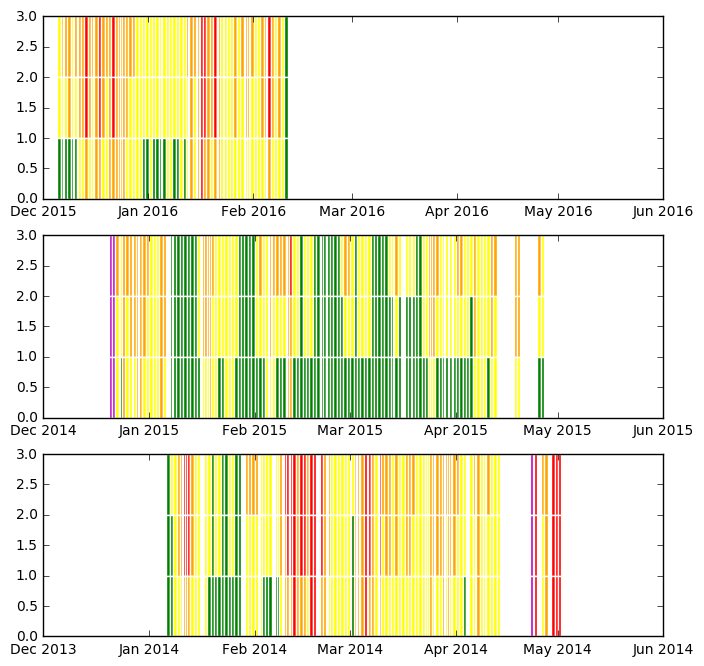

In [137]:
years = (2016, 2015, 2014)

plt.figure(figsize=(12,2))

f,axes = plt.subplots(len(years)) #, sharex=True)
#plt.subplots_adjust(hspace=0)

for ax,year in zip(axes, years):
    drange = snow_year(year)
    df = fetch_ratings(*drange)
    stacked_color_timeline(df, ax=ax)
    ax.set_xlim(drange)
    
#ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%e %b %y'))

plt.savefig('rating_history.pdf')